In [5]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm

# Add repo to the Python path
import sys
sys.path.append("/home/INT/brovelli.a/code/phase_amplitude_encoding/")
from src.models import simulate
from notebooks.spectralMI import spectralMI

In [6]:
jax.config.update("jax_platform_name", "cpu")

### Simulation parameters


In [7]:
# Define time parameters
Nareas = 5
ntrials = 50
fsamp = 1 / 1e-5
t = np.arange(-2., 2., 1 / fsamp)
beta = 1e-4
Npoints = len(t)
decim = 200
dt = 1 / fsamp  # Time step (1 ms resolution)

# Connectivity matrix for a ring model
C = np.array([[0, 1, 0, 0, 0], 
              [0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0]]).T

# Central frequency of neural oscillation
f = 10

### External Input to node 1

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_firing_rate(t, mean=0.5, std_dev=0.3, peak_rate=50):
    """ Gaussian-shaped firing rate (zero before t=0). """
    rate = peak_rate * np.exp(-0.5 * ((t - mean) / std_dev) ** 2)
    rate[t < 0] = 0  # No firing before t=0
    return rate

def boxcar_firing_rate(t, onset=0.2, duration=0.1, rate=50):
    """ Boxcar (rectangular) firing rate: constant firing within a time window. """
    firing_rate = np.zeros_like(t)
    firing_rate[(t >= onset) & (t < onset + duration)] = rate
    return firing_rate

def generate_poisson_spikes(time, rate, dt):
    """ Generates a binary Poisson spike train. """
    return (np.random.rand(len(time)) < (rate * dt)).astype(int)

def convolve_spikes(spike_train, tau=0.1, dt=0.001):
    """ Convolves spike train with an exponential decay filter (corrected length). """
    kernel_length = int(5 * tau / dt)  # Ensure full decay
    t = np.arange(0, kernel_length * dt, dt)
    kernel = np.exp(-t / tau)  # Exponential decay kernel
    kernel /= np.sum(kernel)   # Normalize

    convolved = np.convolve(spike_train, kernel, mode='full')[:len(spike_train)]  # Trim to match length
    return convolved

def simulate_spiking_input(time, mean=0.5, std_dev=0.3, tau=0.1, dt=0.001, peak_rate=50):
    """ Simulates a Poisson spike train with an exponentially decaying memory. """
    rate = gaussian_firing_rate(time, mean, std_dev, peak_rate)
    spike_train = generate_poisson_spikes(time, rate, dt)
    filtered_signal = convolve_spikes(spike_train, tau, dt)
    return spike_train, rate, filtered_signal

def plot_results(time, spike_train, rate, filtered_signal):
    """ Plots the spike train, firing rate, and convolved signal. """
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(time, spike_train, '|', markersize=10, color='black')
    plt.title("Poisson Spike Train")
    plt.xlabel("Time (s)")
    plt.ylabel("Spikes")
    plt.ylim(-0.5, 1.5)
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time, rate, color='red', linewidth=2)
    plt.title("Firing Rate (Gaussian)")
    plt.xlabel("Time (s)")
    plt.ylabel("Rate (Hz)")
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(time, filtered_signal, color='blue', linewidth=2)
    plt.title("Filtered Spike Train (Exponential Memory)")
    plt.xlabel("Time (s)")
    plt.ylabel("Filtered Signal")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Add a loop over trials to simulate the input
# This makes the inputs all different across trials or neurons
ntrials = 50
input_ext_n1 = np.zeros((ntrials, Npoints))
input_ext_n2 = np.zeros((ntrials, Npoints))
input_ext_n3 = np.zeros((ntrials, Npoints))
input_ext_n4 = np.zeros((ntrials, Npoints))
for i in range(ntrials):
    spike_train, rate, input_ext_n1[i] = simulate_spiking_input(t, mean=0.5, std_dev=0.2, tau=0.005, dt=dt, peak_rate=25)
    spike_train, rate, input_ext_n2[i] = simulate_spiking_input(t, mean=0.55, std_dev=0.2, tau=0.005, dt=dt, peak_rate=25)
    spike_train, rate, input_ext_n3[i] = simulate_spiking_input(t, mean=0.6, std_dev=0.2, tau=0.005, dt=dt, peak_rate=25)
    spike_train, rate, input_ext_n4[i] = simulate_spiking_input(t, mean=0.65, std_dev=0.2, tau=0.005, dt=dt, peak_rate=25)
    
# Create External Input matrix for model to node 1
Iext = np.zeros((ntrials, Nareas, Npoints))
# Assign input to node 1
Iext[:, 0, :] = input_ext_n1 * 30
Iext[:, 1, :] = input_ext_n2 * 30
Iext[:, 2, :] = input_ext_n3 * 30
Iext[:, 3, :] = input_ext_n4 * 30
# Create CS matrix
CS =  Iext
seeds = np.random.randint(0, 10000, ntrials)

### Simulate the Hopf network


In [9]:
out = []
for trial in tqdm(range(ntrials)):
    out += [
        simulate(
            C,
            1,
            np.array([f, f, f, f, f]),
            np.array([-3, -3, -3, -3, -3]),
            fsamp,
            beta,
            Npoints,
            CS[trial],
            seeds[trial],
            decim=decim,
            stim_mode="both",
        )
    ]

100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


In [10]:
stims = np.arange(ntrials)
times = t[::decim]
rois = ["1", "2", "3", "4", "5"]
data = xr.DataArray(
        np.stack(out),
        dims=("trials", "roi", "times"),
        coords=(stims,  rois, times) 
        )

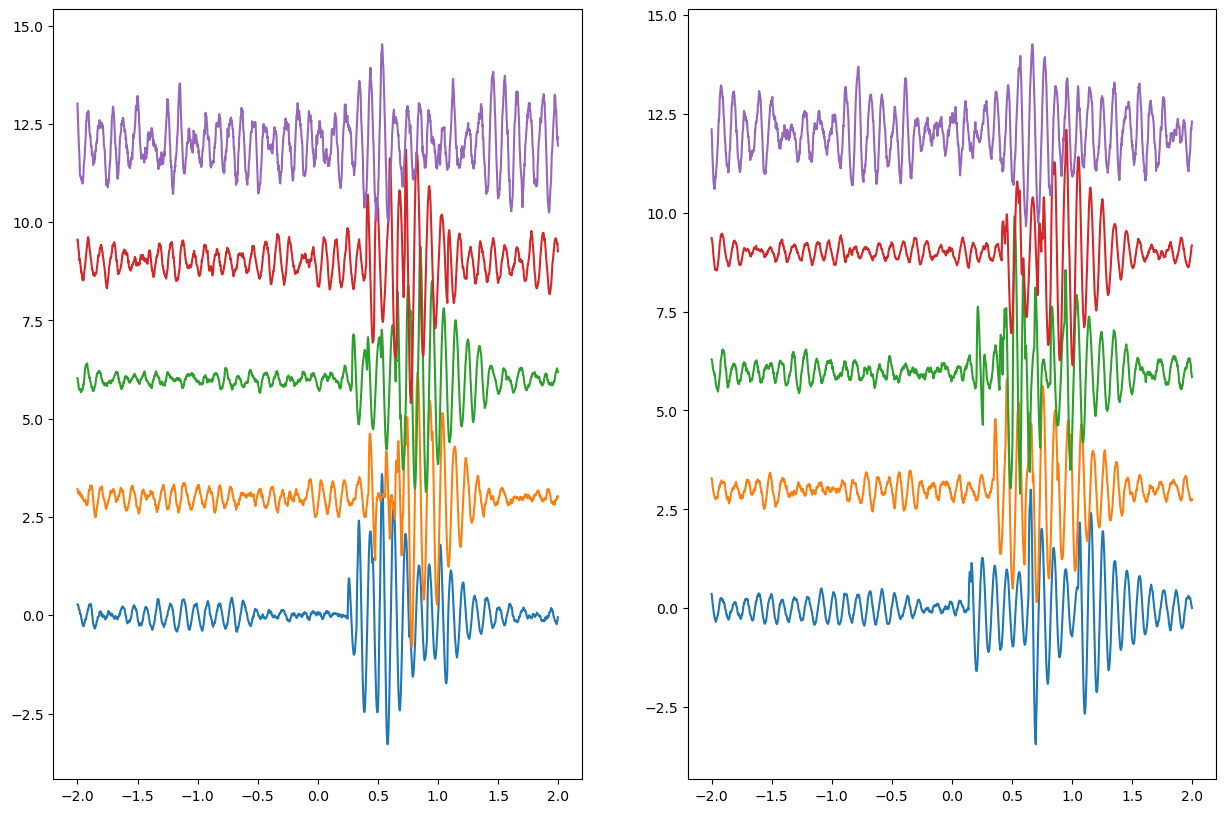

In [11]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

### Coherence analysis

In [12]:
# Params
win = 0.2
step = 0.005
freqs = np.arange(2, 150, 1)
sfreq = fsamp / decim
# Spectral matrix S(n_epochs, n_chans, n_freqs, n_tapers, n_times)
# out = tfr_array_multitaper(data, sfreq=sfreq, freqs=freqs, 
#                            time_bandwidth=5, use_fft=True, decim=1, output='complex', verbose=None)

# Spectral matrix S(n_epochs, n_chans, n_freqs, n_times)
spectra = tfr_array_morlet(data, sfreq=sfreq, freqs=freqs, 
                       n_cycles=freqs/7, use_fft=True, decim=1, output='complex', verbose=None)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


In [13]:
trials = np.arange(ntrials)
# xarray 
S = xr.DataArray(spectra, dims=('trials', 'roi', 'freqs', 'times'),
                 coords=(trials, rois, freqs, times))

In [14]:
from hoi.core import get_mi

# Define the function to compute MI using HOI and JAX
mi_fcn = get_mi("gc")

# vectorize the function to first and second dimension
gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

# Select data for nodes
n1 = S.sel(roi="1").data.squeeze()
n2 = S.sel(roi="2").data.squeeze()
n3 = S.sel(roi="3").data.squeeze()
n4 = S.sel(roi="4").data.squeeze()
n5 = S.sel(roi="5").data.squeeze()

# Power at the node level
p1 = np.abs(n1)**2
p2 = np.abs(n2)**2
p3 = np.abs(n3)**2
p4 = np.abs(n4)**2
p5 = np.abs(n5)**2

# Edge activity (with and without normalisation)
e1 = n1 * np.conj(n2)
e2 = n2 * np.conj(n3)
e3 = n3 * np.conj(n4)
e4 = n4 * np.conj(n5)
e5 = n5 * np.conj(n1)

# Normalise
e1n = e1 / np.abs(e1)
e2n = e2 / np.abs(e2)
e3n = e3 / np.abs(e3)
e4n = e4 / np.abs(e4)
e5n = e5 / np.abs(e5)

# Real and Imag parts pf edge activity
e1r, e1i = np.real(e1), np.imag(e1)
e2r, e2i = np.real(e2), np.imag(e2)
e3r, e3i = np.real(e3), np.imag(e3)
e4r, e4i = np.real(e4), np.imag(e4)
e5r, e5i = np.real(e5), np.imag(e5)

# Real and Imag parts of edge activity normalised
e1nr, e1ni = np.real(e1n), np.imag(e1n)
e2nr, e2ni = np.real(e2n), np.imag(e2n)
e3nr, e3ni = np.real(e3n), np.imag(e3n)
e4nr, e4ni = np.real(e4n), np.imag(e4n)
e5nr, e5ni = np.real(e5n), np.imag(e5n)

# Stack complex values
E1 = np.stack((e1r, e1i), axis=1)   
E2 = np.stack((e2r, e2i), axis=1)
E3 = np.stack((e3r, e3i), axis=1)
E4 = np.stack((e4r, e4i), axis=1)
E5 = np.stack((e5r, e5i), axis=1)

# Stack normalised complex values
E1n = np.stack((e1nr, e1ni), axis=1)
E2n = np.stack((e2nr, e2ni), axis=1)
E3n = np.stack((e3nr, e3ni), axis=1)
E4n = np.stack((e4nr, e4ni), axis=1)
E5n = np.stack((e5nr, e5ni), axis=1)


# Swap axis 0 with 3 and 1 with 2
E1 = np.moveaxis(E1, [0, 1], [-1, -2])
E2 = np.moveaxis(E2, [0, 1], [-1, -2])
E3 = np.moveaxis(E3, [0, 1], [-1, -2])
E4 = np.moveaxis(E4, [0, 1], [-1, -2])
E5 = np.moveaxis(E5, [0, 1], [-1, -2])

# Swap normalised axis 0 with 3 and 1 with 2
E1n = np.moveaxis(E1n, [0, 1], [-1, -2])
E2n = np.moveaxis(E2n, [0, 1], [-1, -2])
E3n = np.moveaxis(E3n, [0, 1], [-1, -2])
E4n = np.moveaxis(E4n, [0, 1], [-1, -2])
E5n = np.moveaxis(E5n, [0, 1], [-1, -2])

# Stims across trials
stim = trials
stim = np.expand_dims(stim, axis=(0, 1))
stim = np.tile(stim, (len(freqs), len(times), 1, 1))

# # MI frequency domain
# mi_freq[i, :] = gcmi_nd_cc(X, Y, mvaxis=1, traxis=0)

# Coherence
coh1 = np.abs(e1.mean(axis=0)).squeeze()
coh2 = np.abs(e2.mean(axis=0)).squeeze()
coh3 = np.abs(e3.mean(axis=0)).squeeze()
coh4 = np.abs(e4.mean(axis=0)).squeeze()
coh5 = np.abs(e5.mean(axis=0)).squeeze()

# Phase-Locking Value
plv1 = np.abs(e1n.mean(axis=0)).squeeze()
plv2 = np.abs(e2n.mean(axis=0)).squeeze()
plv3 = np.abs(e3n.mean(axis=0)).squeeze()
plv4 = np.abs(e4n.mean(axis=0)).squeeze()
plv5 = np.abs(e5n.mean(axis=0)).squeeze()

# # Normalised power at the node level wrt baseline from -2 to 0
# p1 = (p1 - p1[..., times < -0.2].mean(axis=-1, keepdims=True)) / p1[..., times < -0.2].std(axis=-1, keepdims=True)
# p2 = (p2 - p2[..., times < -0.2].mean(axis=-1, keepdims=True)) / p2[..., times < -0.2].std(axis=-1, keepdims=True)
# p3 = (p3 - p3[..., times < -0.2].mean(axis=-1, keepdims=True)) / p3[..., times < -0.2].std(axis=-1, keepdims=True)
# p4 = (p4 - p4[..., times < -0.2].mean(axis=-1, keepdims=True)) / p4[..., times < -0.2].std(axis=-1, keepdims=True)
# p5 = (p5 - p5[..., times < -0.2].mean(axis=-1, keepdims=True)) / p5[..., times < -0.2].std(axis=-1, keepdims=True)

# Average power
pow1 = p1.mean(axis=0).squeeze()
pow2 = p2.mean(axis=0).squeeze()
pow3 = p3.mean(axis=0).squeeze()
pow4 = p4.mean(axis=0).squeeze()
pow5 = p5.mean(axis=0).squeeze()


# # Copnorm
# E1 = copnorm_nd(E1, axis=-1)
# E2 = copnorm_nd(E2, axis=-1)
# E3 = copnorm_nd(E3, axis=-1)
# E4 = copnorm_nd(E4, axis=-1)
# E5 = copnorm_nd(E5, axis=-1)
# E12 = copnorm_nd(E12, axis=-1)
# E23 = copnorm_nd(E23, axis=-1)
# E123 = copnorm_nd(E123, axis=-1)
# stim = copnorm_nd(stim, axis=-1)

# # MIF for edge encoding
# mif_e1 = gcmi(E1, stim).T
# mif_e2 = gcmi(E2, stim).T
# mif_e3 = gcmi(E3, stim).T
# mif_e12 = gcmi(E12, stim).T
# mif_e23 = gcmi(E23, stim).T
# mif_e123 = gcmi(E123, stim).T

# red = np.minimum(mif_e1, mif_e2)

# syn = mif_e123 - np.maximum(mif_e1, mif_e2)

In [15]:
coherence = np.stack((coh1.T, coh2.T, coh3.T, coh4.T, coh5.T), axis=0)
phasesync = np.stack((plv1.T, plv2.T, plv3.T, plv4.T, plv5.T), axis=0)
power = np.stack((pow1.T, pow2.T, pow3.T, pow4.T, pow5.T), axis=0)

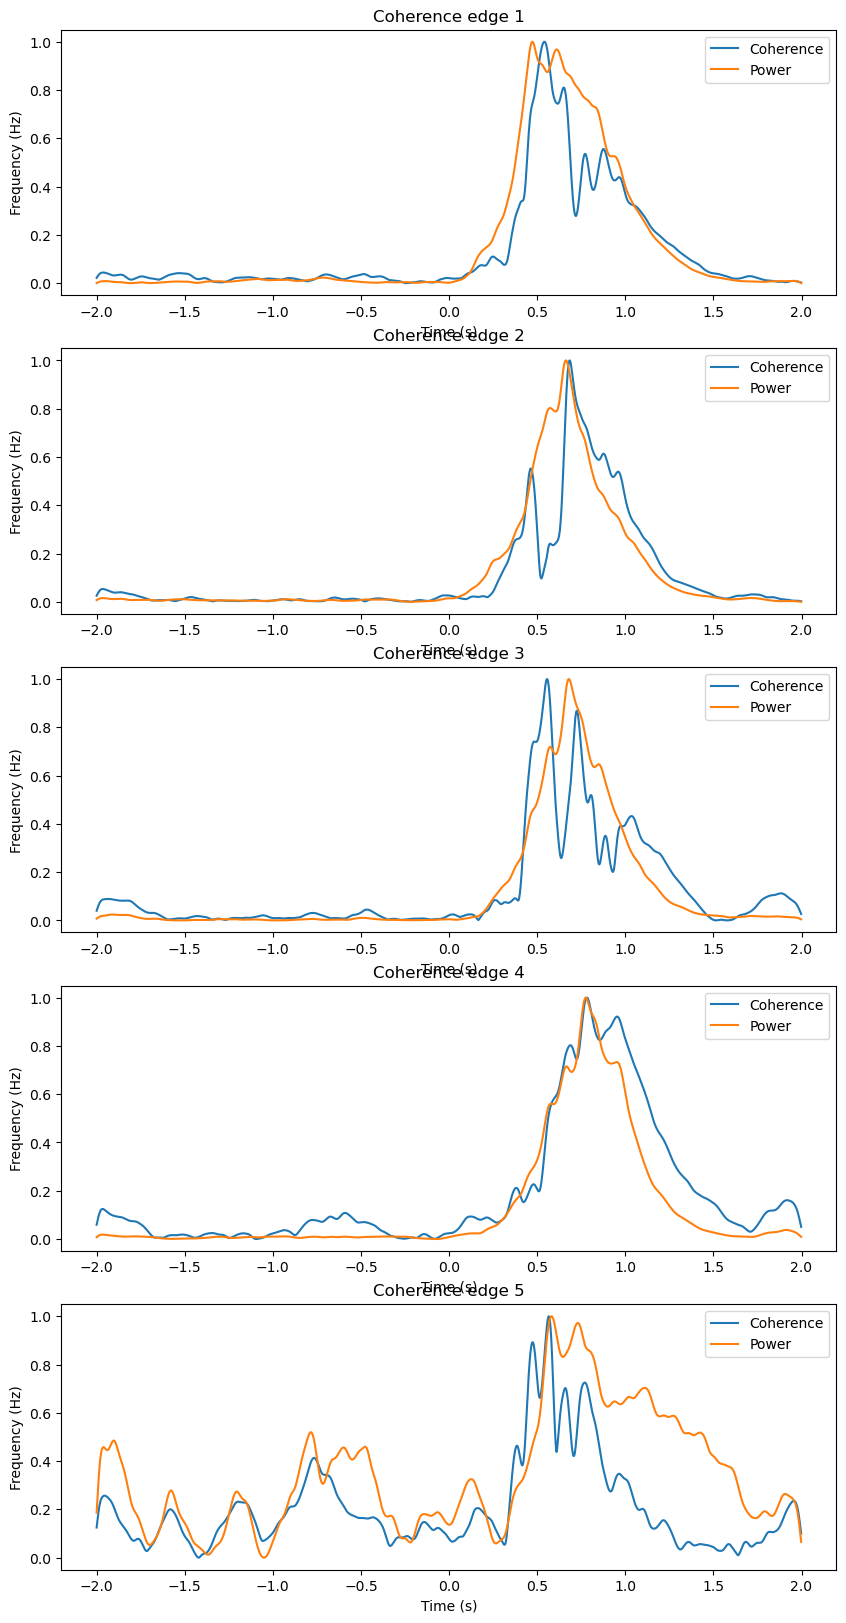

In [16]:
# Plot coherence in subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for i, ax in enumerate(axes):

    coh = xr.DataArray(coherence[i], dims=('times', 'freqs'), coords=(times,freqs))
    # average over frequencies
    coh = coh.mean('freqs')
    # normalise to [0, 1]
    coh = (coh - coh.min()) / (coh.max() - coh.min())

    plv = xr.DataArray(phasesync[i], dims=('times', 'freqs'), coords=(times,freqs))
    # average over frequencies
    plv = plv.mean('freqs')
    # normalise to [0, 1]
    plv = (plv - plv.min()) / (plv.max() - plv.min())

    pow = xr.DataArray(power[i], dims=('times', 'freqs'), coords=(times,freqs))
    # average over frequencies
    pow = pow.mean('freqs')
    # normalise to [0, 1]
    pow = (pow - pow.min()) / (pow.max() - pow.min())


    # Plot the mean coh and pow on the same panel
    coh.plot(ax=ax, label='Coherence')
    pow.plot(ax=ax, label='Power')
    # plv.plot(ax=ax, label='PLV')


    #mi.plot.title('ciao')
    ax.set_title("Coherence edge %d" % (i + 1))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    # add legend
    ax.legend()

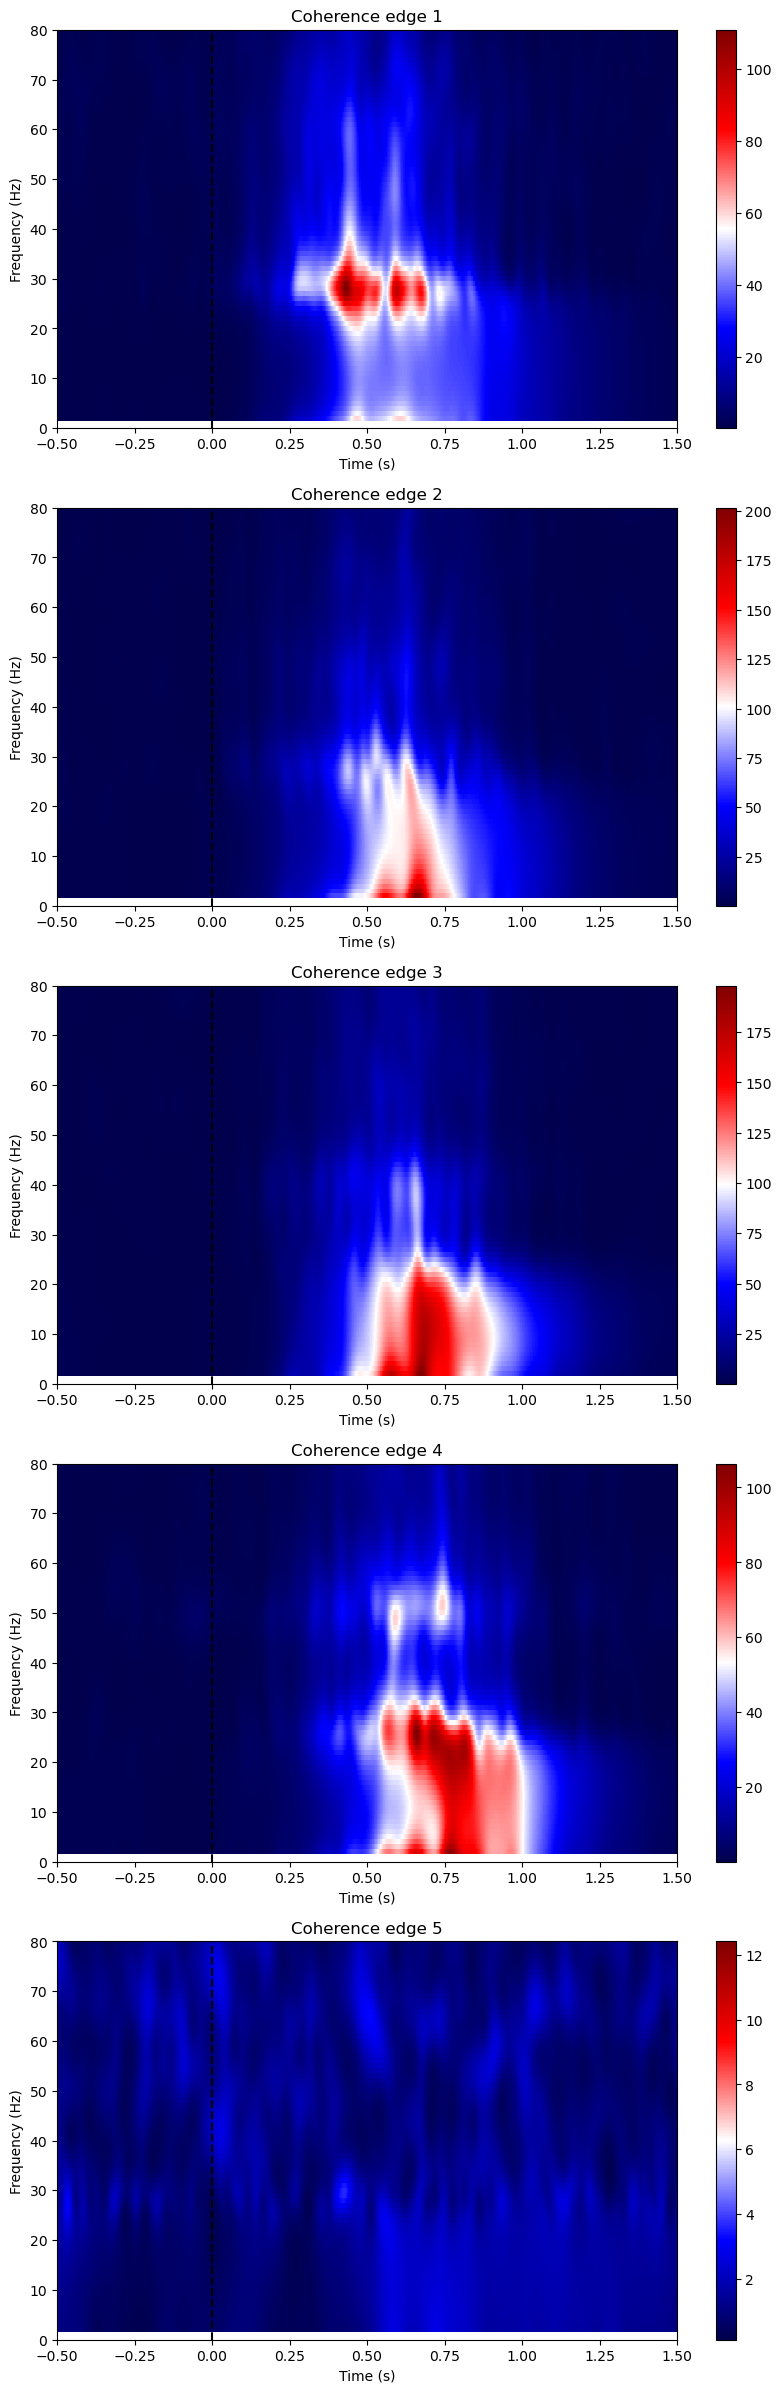

In [17]:
# Plot coherence in subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 30))

for i, ax in enumerate(axes):

    coh = xr.DataArray(coherence[i], dims=('times', 'freqs'), coords=(times,freqs))
    plv = xr.DataArray(phasesync[i], dims=('times', 'freqs'), coords=(times,freqs))
    pow = xr.DataArray(power[i], dims=('times', 'freqs'), coords=(times,freqs))

    # Normalise power with respect to baseline from -1 to 0 seconds
    pow = pow / pow.sel(times=slice(-1., -0.5)).mean('times')
    # pow = (pow - pow.sel(times=slice(-1.5, -0.5)).mean('times'))  / pow.sel(times=slice(-1.5, -0.5)).mean('times')

    # Plot trial-average time-frequency MI in subplot
    pow.plot(x='times', y='freqs', cmap='seismic', ax=ax)
    #mi.plot.title('ciao')
    ax.set_title("Coherence edge %d" % (i + 1))
    # xlim to 0 to 0.5 seconds
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0, 80)
    ax.set_xlabel('Time (s)')
    # add line at zero time
    ax.axvline(0, color='black', linestyle='--')
    ax.set_ylabel('Frequency (Hz)')
